In [1]:
import torch
import sys
import torch
import os.path as osp
import tqdm
import sys
import numpy as np
sys.path.append('/afs/cern.ch/work/m/mgarciam/private/mlpf/')
from src.dataset.dataset import SimpleIterDataset
from src.utils.utils import to_filelist
from torch.utils.data import DataLoader
import dgl
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [106]:
class Args:
    def __init__(self):
        self.data_train = ["/eos/user/m/mgarciam/datasets_mlpf/120823_condor_spread_15_20/pf_tree_1.root"]
        self.data_val = ['/eos/user/m/mgarciam/datasets_mlpf/120823_condor_spread_15_20/pf_tree_1.root']
        #self.data_train = files_train
        self.data_config = '/afs/cern.ch/work/m/mgarciam/private/mlpf/config_files/config_2_newlinks.yaml'
        self.extra_selection = None
        self.train_val_split = 0.8
        self.data_fraction = 1
        self.file_fraction = 1
        self.fetch_by_files = False
        self.fetch_step = 0.01
        self.steps_per_epoch = None
        self.in_memory = False
        self.local_rank = None
        self.copy_inputs = False
        self.no_remake_weights = False
        self.batch_size = 2
        self.num_workers = 0
        self.demo = False
        self.laplace = False
        self.diffs = False
        self.class_edges = False
args = Args()
train_range = (args.train_val_split, 1)
train_file_dict, train_files = to_filelist(args, 'train')

In [107]:
train_data = SimpleIterDataset(train_file_dict, args.data_config, for_training=True,
                                   extra_selection=args.extra_selection,
                                   remake_weights= True,
                                   load_range_and_fraction=(train_range, args.data_fraction),
                                   file_fraction=args.file_fraction,
                                   fetch_by_files=args.fetch_by_files,
                                   fetch_step=args.fetch_step,
                                   infinity_mode= False,
                                   in_memory=args.in_memory,
                                   async_load = False,
                                   name='train', dataset_cap=None)

In [108]:
from src.dataset.functions_graph import graph_batch_func

train_loader = DataLoader(train_data, batch_size=3, drop_last=True, pin_memory=True,
                          num_workers=min(args.num_workers, int(len(train_files) * args.file_fraction)),
                          collate_fn=graph_batch_func,
                          persistent_workers=args.num_workers > 0 and args.steps_per_epoch is not None)

In [138]:
iterator = iter(train_loader)

=== Restarting DataIter train, seed=None ===


In [164]:
g, y = next(iterator)

In [111]:
len(dgl.unbatch(g))

3

In [112]:

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


In [165]:
from src.models.wrapper.example_EGNN import EGNNNetWrapper
model = EGNNNetWrapper('cpu') #output_dim =4, n_postgn_dense_blocks=4, clust_space_norm = "tanh", k_gravnet=10)
# from src.models.wrapper.example_gattedGCN import GatedGCNNetWrapper
# model = GatedGCNNetWrapper('cpu')


new_model = "/eos/user/g/gkrzmanc/mlpf_data/model_14aug_ds15_qmin3/_epoch-32_state.pt"  # 16D clustering space
model.load_state_dict(torch.load(new_model, map_location='cpu'))

<All keys matched successfully>

In [166]:
pred = model(g)

In [180]:
from src.layers.obj_cond_inf import calc_energy_loss
batch = g 
cluster_space_coords = pred[:,0:3]
beta = torch.sigmoid(torch.reshape(pred[:,3], [-1, 1]))
loss_E_frac, [loss_E_frac_true, particle_ids_all, reco_count, non_reco_count, total_count] = calc_energy_loss(
    batch, cluster_space_coords, beta, beta_stabilizing="soft_q_scaling", qmin=3, radius=0.4,
    e_frac_loss_return_particles=True, y=y, select_centers_by_particle=True
)

No. of objects 15
Radius 0.4
No. of objects 15
Radius 0.4
No. of objects 15
Radius 0.4


In [186]:
loss_E_frac[2]

tensor([0.9536, 1.0538, 2.6553, 0.0409, 0.3821, 0.3917, 0.9194, 5.7243, 1.0139,
        1.1780, 0.0164, 1.0000, 0.9356, 0.9825, 1.0000])

15
15
0.7763692


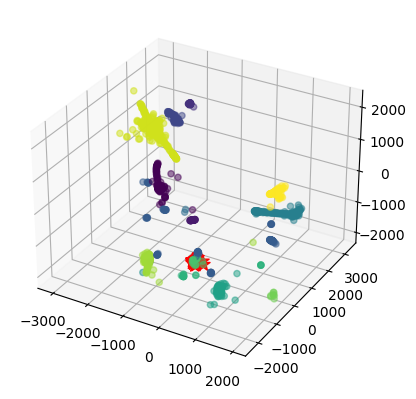

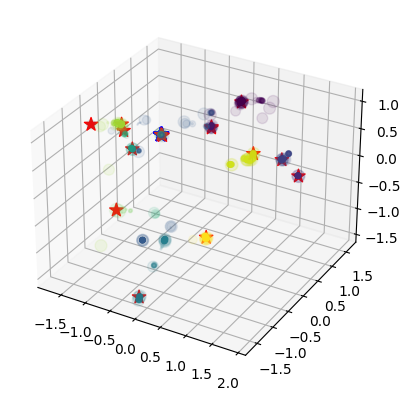

In [241]:
pp=11
g.ndata['pred']=pred
list_graphs = dgl.unbatch(g)
g_eval=list_graphs[2]
pred_val = g_eval.ndata['pred']
pos = g_eval.ndata['pos_hits_norm']
pos_xyz = g_eval.ndata['pos_hits_xyz']
particle_id = g_eval.ndata['particle_number']
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
print(len(torch.unique(particle_id)))
ax.scatter(pos_xyz[:,0], pos_xyz[:,1], pos_xyz[:,2],marker='o', c = particle_id, alpha=0.5)
ax.scatter(pos_xyz[particle_id==pp][:,0], pos_xyz[particle_id==pp][:,1], pos_xyz[particle_id==pp][:,2],marker='*', c = "red", alpha=1, s=100)

pred_val = g_eval.ndata['pred']
pos = g_eval.ndata['pos_hits_norm']
pos_xyz = pred_val[:,0:3].detach().numpy()
betas = torch.sigmoid(pred_val[:,3]).detach().numpy()
particle_id = g_eval.ndata['particle_number']
particle_id = g_eval.ndata["particle_number"]
_, selected_centers = scatter_max(
    pred_val[:,3].flatten().cpu(), particle_id.cpu().long() - 1
)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
print(len(torch.unique(particle_id)))
ax.scatter(pos_xyz[:,0], pos_xyz[:,1], pos_xyz[:,2],marker='o', c = particle_id, alpha=0.1, s=betas*100)
ax.scatter(pos_xyz[selected_centers][:,0], pos_xyz[selected_centers][:,1], pos_xyz[selected_centers][:,2],marker='*', c = "red", alpha=1, s=100)
ax.scatter(pos_xyz[particle_id==pp][:,0], pos_xyz[particle_id==pp][:,1], pos_xyz[particle_id==pp][:,2],marker='*', c = "blue", alpha=1, s=100)
#ax.scatter(pos_xyz[selected_centers[pp-1]][0], pos_xyz[selected_centers[pp-1]][1], pos_xyz[selected_centers[pp-1]][2],marker='o', c = "blue", alpha=1, s=100)
print(np.max(betas[particle_id==pp]))

In [252]:
pick_ = torch.argsort(torch.cdist(torch.Tensor(pos_xyz[selected_centers]),torch.Tensor(pos_xyz[selected_centers]),p=2),dim=1)[:,1]

In [260]:
pos_xyz[selected_centers]

array([[ 0.17881697,  1.1581892 ,  0.8346509 ],
       [-0.352052  ,  1.0458919 ,  0.29884395],
       [ 1.8711164 ,  0.19872314,  0.38552797],
       [ 1.5462611 ,  0.20440659,  0.5901969 ],
       [-1.036354  ,  0.552396  ,  0.20305938],
       [-0.3529518 ,  1.0449234 ,  0.2791649 ],
       [-0.09254839, -1.596902  , -1.4181074 ],
       [-1.4789929 , -0.89329886,  0.9896666 ],
       [-1.6268439 ,  0.48791143, -0.16746941],
       [-1.4678633 ,  0.01268624,  0.4468419 ],
       [-1.0689144 ,  0.56134456,  0.20789608],
       [-1.5204422 , -0.1802203 , -0.9619065 ],
       [-1.1235673 , -0.5282249 ,  0.90772724],
       [ 1.4120519 , -0.4879884 ,  1.005302  ],
       [ 0.2791388 , -0.11310665, -1.0171709 ]], dtype=float32)

: 

In [258]:
torch.cdist(torch.Tensor(pos_xyz[selected_centers]),torch.Tensor(pos_xyz[selected_centers]),p=2).gather(1,pick_.view(-1,1))

tensor([[0.7626],
        [0.0197],
        [0.3840],
        [0.3840],
        [0.0341],
        [0.0197],
        [1.5813],
        [0.5161],
        [0.6764],
        [0.7192],
        [0.0341],
        [1.0435],
        [0.5161],
        [0.8184],
        [1.5813]])

In [ ]:
x1 = torch.Tensor(pos_xyz[particle_id==pp])
x2 = torch.Tensor(pos_xyz[selected_centers[[10,4]]])
dist_v = torch.cdist(x1, x2, p=2.0)



In [235]:
dist_v[:,0]

tensor([0.0268, 0.0217, 0.0218, 0.0225, 0.0226, 0.0223, 0.0202, 0.0217, 0.0190,
        0.0098, 0.0118, 0.0097, 0.0098, 0.0097, 0.0072, 0.0085, 0.0057, 0.0000,
        0.0032, 0.0139, 0.0148, 0.0152, 0.0145, 0.0072, 0.0140, 0.0100, 0.0151,
        0.0148, 0.0279, 0.0278, 0.0235, 0.0316, 0.0250, 0.0259])

In [237]:
dist_v[:,1]

tensor([0.0372, 0.0276, 0.0274, 0.0271, 0.0243, 0.0260, 0.0287, 0.0279, 0.0315,
        0.0386, 0.0447, 0.0417, 0.0416, 0.0415, 0.0380, 0.0401, 0.0378, 0.0341,
        0.0369, 0.0456, 0.0462, 0.0463, 0.0459, 0.0395, 0.0452, 0.0408, 0.0446,
        0.0470, 0.0605, 0.0191, 0.0207, 0.0243, 0.0225, 0.0253])

<Axes: ylabel='Count'>

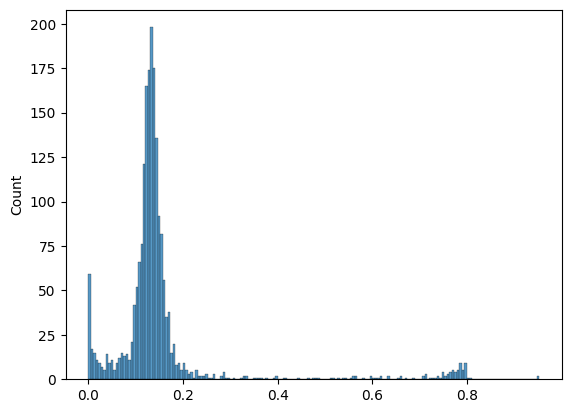

In [192]:
import seaborn
seaborn.histplot(betas)

In [99]:
particle_id[betas>0.5]

tensor([])

In [40]:
from torch_scatter import scatter_max, scatter_add, scatter_mean
particle_id = g_eval.ndata["particle_number"]
_, selected_centers = scatter_max(
    pred_val[:,3].flatten().cpu(), particle_id.cpu().long() - 1
)

In [41]:
selected_centers

tensor([ 730,  620, 1484, 1463,  562, 1922, 1797,  535,  525, 1457, 1344, 1673,
         402])

In [45]:
particle_id

tensor([13., 13., 13.,  ...,  6.,  6.,  6.])

In [43]:
g_eval.ndata["particle_number"][730]

tensor(1.)